In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
%matplotlib inline

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [38]:
def readLangs_old(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def readLangs(lang1, lang2, reverse=False, dataset="train"):
    print("Reading lines...")

    assert (lang1 in ["en", "da", "nb", "sv"]) & (lang2 in ["en", "da", "nb", "sv"])

    # Read the file and split into lines

    lines_metadata = np.array(open(f'../../data/{dataset}.metadata', encoding='utf-8').\
    read().strip().split('\n'))
    lines_src = np.array(open(f'../../data/{dataset}.src', encoding='utf-8').\
        read().strip().split('\n'))
    lines_tgt = np.array(open(f'../../data/{dataset}.tgt', encoding='utf-8').\
        read().strip().split('\n'))
    lines = np.where(lines_metadata=='{"src_lang": "%s", "tgt_lang": "%s"}' % (lang1, lang2))[0]

    # Split every line into pairs and normalize
    pairs = [[normalizeString(l1), normalizeString(l2)] for l1, l2 in zip(lines_src[lines], lines_tgt[lines])]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [39]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [41]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('en', 'da', True)
print(random.choice(pairs))

Reading lines...
Read 108729 sentence pairs
Trimmed to 155 sentence pairs
Counting words...
Counted words:
da 406
en 390
['hjemmeside produkter mate maskiner', 'you are here home products feed machinery']


In [61]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [43]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [44]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [93]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size, input_lang_code, output_lang_code):
    input_lang, output_lang, pairs = prepareData(input_lang_code, output_lang_code, True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [54]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [55]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [70]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [57]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [58]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [59]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Reading lines...
Read 108729 sentence pairs
Trimmed to 155 sentence pairs
Counting words...
Counted words:
da 406
en 390
0m 0s (- 0m 6s) (5 6%) 4.2985
0m 1s (- 0m 7s) (10 12%) 2.7342
0m 1s (- 0m 6s) (15 18%) 2.2157
0m 1s (- 0m 5s) (20 25%) 1.8457
0m 2s (- 0m 5s) (25 31%) 1.5173
0m 2s (- 0m 4s) (30 37%) 1.2170
0m 3s (- 0m 4s) (35 43%) 0.9584
0m 3s (- 0m 3s) (40 50%) 0.7506
0m 4s (- 0m 3s) (45 56%) 0.5928
0m 4s (- 0m 2s) (50 62%) 0.4778
0m 5s (- 0m 2s) (55 68%) 0.3959
0m 5s (- 0m 1s) (60 75%) 0.3304
0m 6s (- 0m 1s) (65 81%) 0.2762
0m 6s (- 0m 0s) (70 87%) 0.2339
0m 7s (- 0m 0s) (75 93%) 0.1956
0m 7s (- 0m 0s) (80 100%) 0.1647


<Figure size 640x480 with 0 Axes>

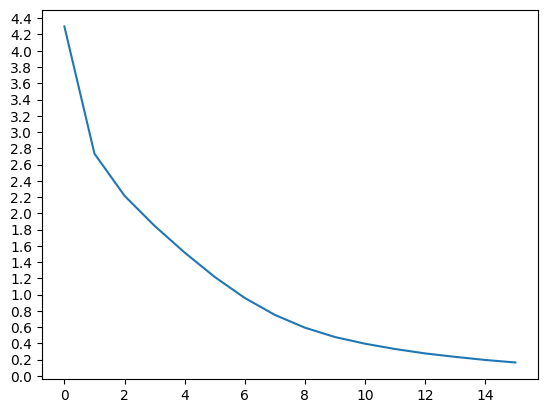

In [94]:
hidden_size = 128
batch_size = 32
input_lang_code = "en"
output_lang_code = "da"

input_lang, output_lang, train_dataloader = get_dataloader(batch_size, input_lang_code=input_lang_code, output_lang_code=output_lang_code)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

plot_losses = train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [79]:
# torch.save(encoder.state_dict(), f'encoder_{input_lang}_{output_lang}.pth')
# model_test = EncoderRNN()
model_test = EncoderRNN(input_lang.n_words, hidden_size).to(device)
# decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
model_test.load_state_dict(torch.load(f'encoder_{input_lang}_{output_lang}.pth'))

<All keys matched successfully>

In [95]:
def save_model(encoder, decoder, input_lang_code, output_lang_code):
    torch.save(encoder.state_dict(), f'encoder_{input_lang_code}_{output_lang_code}.pth')
    torch.save(decoder.state_dict(), f'decoder_{input_lang_code}_{output_lang_code}.pth')

In [99]:
def load_model(encoder, decoder, input_lang_code, output_lang_code):
    encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
    encoder.load_state_dict(torch.load(f'encoder_{input_lang_code}_{output_lang_code}.pth'))
    decoder.load_state_dict(torch.load(f'decoder_{input_lang_code}_{output_lang_code}.pth'))
    return encoder, decoder

In [97]:
save_model(encoder, decoder, input_lang_code, output_lang_code)

In [100]:
encoder_test, decoder_test = load_model(encoder, decoder, input_lang_code, output_lang_code)

In [101]:
encoder_test.eval()
decoder_test.eval()
evaluateRandomly(encoder_test, decoder_test)

> du er her startside web hosting service sammenligne planer
= you are here home web hosting service compare plans
< you are here home web hosting service compare plans <EOS>

> er du her vigtigste producenter dikson
= you are here home manufacturers dikson
< you are here home manufacturers dikson <EOS>

> bogen er en inspirerende hyldest til
= you are cool and inspiring !
< you are cool and inspiring ! <EOS>

> du chatter ikke mere med reniahot
= you re no longer in chat mode with reniahot
< you re no longer in chat mode with reniahot <EOS>

> alting fungerer altid !
= we are close to everything
< we are close to everything ! <EOS>

> du er i solbriller lifestyle bolle solbriller
= you are in sunglasses lifestyle bolle sunglasses
< you are in sunglasses lifestyle bolle sunglasses <EOS>

> jeg er ked af du er skuffet
= i m sorry you re disappointed
< i m sorry you re disappointed <EOS>

> du er her rad og tips
= you are here advices tips
< you are here advices tips <EOS>

> vi slar sam

In [102]:
import evaluate

metric = evaluate.load("sacrebleu")

In [103]:
predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]

In [104]:
metric.compute(predictions=predictions, references=references)

{'score': 46.750469682990165,
 'counts': [11, 6, 4, 3],
 'totals': [12, 11, 10, 9],
 'precisions': [91.66666666666667,
  54.54545454545455,
  40.0,
  33.333333333333336],
 'bp': 0.9200444146293233,
 'sys_len': 12,
 'ref_len': 13}

In [72]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> du motiveres af at bygge en god brugeroplevelse
= you are motivated by building a good user experience
< you are motivated by building a good user experience <EOS>

> du er her hjem thermomix champignon pandekager
= you are here home thermomix mushroom crepes
< you are here home thermomix mushroom crepes <EOS>

> vi bygger pa den nyeste viden
= we are building upon the newest knowledge
< we are building upon the newest knowledge <EOS>

> du er her hjem desserter kager nutella kage
= you are here home desserts cakes nutella cake
< you are here home desserts cakes nutella cake <EOS>

> du er inde sport vores sport brands
= you are in sports our sports brands
< you are in sports our sports brands <EOS>

> du er i solbriller rita chloe solbriller
= you are in sunglasses rita chloe sunglasses
< you are in sunglasses rita chloe sunglasses <EOS>

> du er her hjem produkter heat transfer materiale
= you are here home products heat transfer material
< you are here home products heat transfer 

In [73]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

input = du motiveres af at bygge en god brugeroplevelse
output = you are motivated by building a good user experience <EOS>


/var/folders/6z/ksp4bzwx2bdgrt3jgvdfnr6r0000gn/T/ipykernel_34209/2731457559.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/6z/ksp4bzwx2bdgrt3jgvdfnr6r0000gn/T/ipykernel_34209/2731457559.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


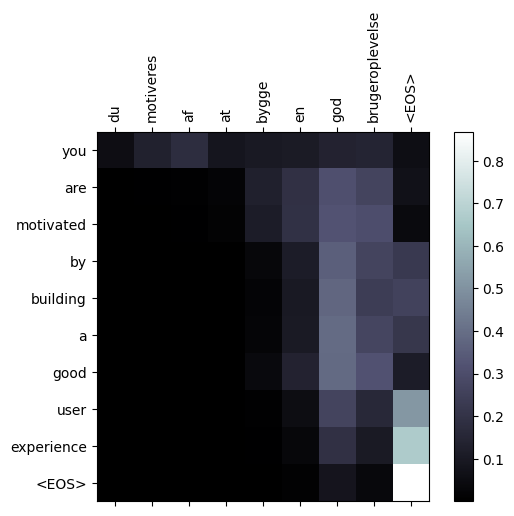

input = du er her hjem thermomix champignon pandekager
output = you are here home thermomix mushroom crepes <EOS>


/var/folders/6z/ksp4bzwx2bdgrt3jgvdfnr6r0000gn/T/ipykernel_34209/2731457559.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/6z/ksp4bzwx2bdgrt3jgvdfnr6r0000gn/T/ipykernel_34209/2731457559.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


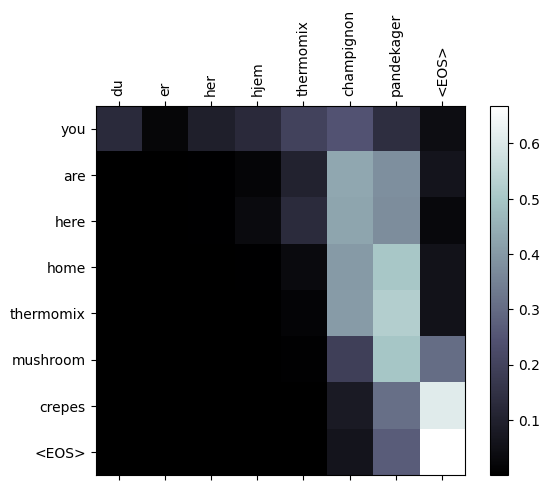

input = vi bygger pa den nyeste viden
output = we are building upon the newest knowledge <EOS>


/var/folders/6z/ksp4bzwx2bdgrt3jgvdfnr6r0000gn/T/ipykernel_34209/2731457559.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/6z/ksp4bzwx2bdgrt3jgvdfnr6r0000gn/T/ipykernel_34209/2731457559.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


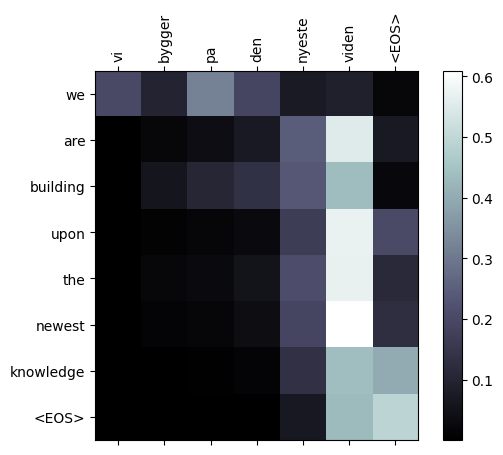

input = du er i solbriller rita chloe solbriller
output = you are in sunglasses rita chloe sunglasses <EOS>


/var/folders/6z/ksp4bzwx2bdgrt3jgvdfnr6r0000gn/T/ipykernel_34209/2731457559.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/6z/ksp4bzwx2bdgrt3jgvdfnr6r0000gn/T/ipykernel_34209/2731457559.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


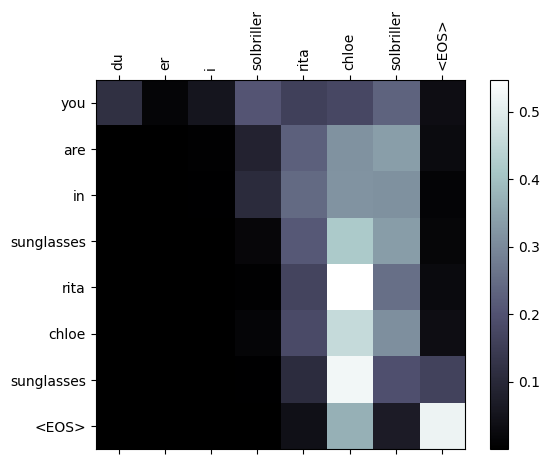

In [76]:
evaluateAndShowAttention('du motiveres af at bygge en god brugeroplevelse')

evaluateAndShowAttention('du er her hjem thermomix champignon pandekager')

evaluateAndShowAttention('vi bygger pa den nyeste viden')

evaluateAndShowAttention('du er i solbriller rita chloe solbriller')